*执行下面的代码前需确保数据集已被解压到相对位置data目录中，data目录中为如下结构*
- *imgs*
    - *train*
        - *c0*
        - *c1*
        - *c2*
        - ......
    - *test*
    - *preview*
- *driver_imgs_list.csv*
- *sample_submission.csv*

*同时需要创建saved_weights目录*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.model_selection import GroupKFold
import imageio
%matplotlib inline

Using TensorFlow backend.


In [2]:
drivers_pd = pd.read_csv("data/driver_imgs_list.csv")

In [3]:
drivers_pd.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# 分析
## 数据探索

数据集来源于往年的Kaggle竞赛。数据集中包含大量车载摄像头对驾驶员位置的摄影截图，可清楚看到驾驶员的各种行为，包括打电话、喝饮料、拿后面的东西、打字等。

数据集中将图片数据分为了训练集和测试集，训练集可用于该项目中训练模型，测试集可在模型训练完毕后检验预测效果，可提交至Kaggle中计算已训练模型的最终得分。

训练集中已将图像标记分类，分为c0到c9一共十个文件夹存放，共22424张图片。测试集中有79729张未标记分类的图片。

数据集中每一张图片大小为640*480像素。图片中的驾驶员各种各样，有胖有瘦，有高有矮，有男有女、甚至还有不同肤色的驾驶员，有的驾驶员手臂上还有纹身。图片的光线有明，也有暗，甚至还有些有点爆光过度，导致难以发现手中的透明杯子。

因光照原因，看不见手中的水杯

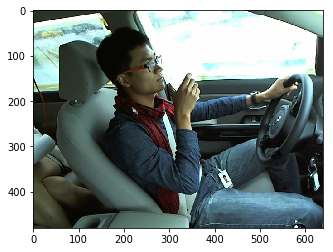

In [5]:
img = imageio.imread("data/imgs/train/c6/img_16.jpg")
plt.imshow(img)
plt.show()

非常胖的驾驶员

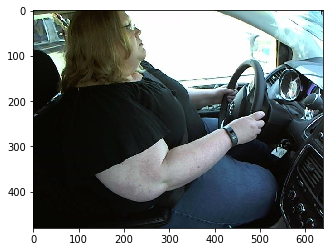

In [6]:
img = imageio.imread("data/imgs/train/c0/img_104.jpg")
plt.imshow(img)
plt.show()

图像模糊

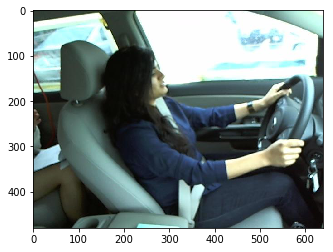

In [7]:
img = imageio.imread("data/imgs/train/c0/img_316.jpg")
plt.imshow(img)
plt.show()

## 探索性可视化

In [8]:
drivers_pd.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_38338.jpg
freq,1237,2489,1


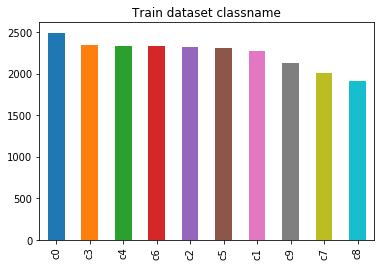

In [9]:
drivers_pd["classname"].value_counts().plot(kind="bar", title="Train dataset classname")

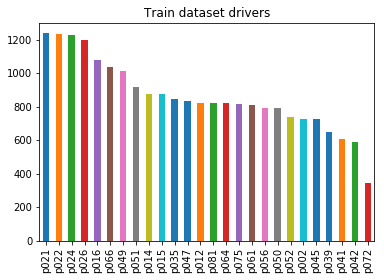

In [10]:
drivers_pd["subject"].value_counts().plot(kind="bar", title="Train dataset drivers")

从数据集中的driver_imgs_list.csv文件中可得处一些关于该数据集的信息：
- 总共有22424张已标记图像
- 总共有26名驾驶员的不同状态的图像，每名驾驶员的图像数量并不完全相同，最多的驾驶员有1237张图像，最少的驾驶员只有346张图像
- 总共有10种不同的驾驶状态，且每种状态的图片数量差别不大，即它们呈均匀分布

In [11]:
drivers_pd["subject"].value_counts()

p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p012     823
p081     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: subject, dtype: int64

## 算法和技术
### Tensorflow
Tensorflow是一个Google公司开发的基于数据流图计算的人工智能神经网络处理框架，可广泛应用于如语音识别，自然语言理解，计算机视觉，广告等。
### Keras
Keras是一个高层神经网络API，基于tensorflow、Theano以及CNTK后端框架的上层框架，让tensorflow等基础神经网络框架更易于使用。
### 数据增强
由于图像有明有暗，司机在图像中所处的位置也不同，甚至有些图片比较模糊，决定在训练之前对分割出的训练图像和验证图像做数据增强处理。

数据增强是将图片变换处理出多式多样的不同副本，图像中的主要内容不变，但经过数据增强预处理的图像会被挤压、缩小、旋转角度、添加噪点、Dropout、模糊处理、提升亮度、降低亮度等，将图像这样预处理后模型将有机会认识到图像的各种形态，增加模型的鲁棒性和泛化能力。

这里将尝试使用Keras中的图像预处理器对任意挑选的一张图片做预处理实验

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

img = load_img('data/imgs/train/c0/img_316.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/imgs/preview', save_prefix='c0', save_format='jpeg'):
    i += 1
    if i > 20:
        break

预处理图像后的结果：

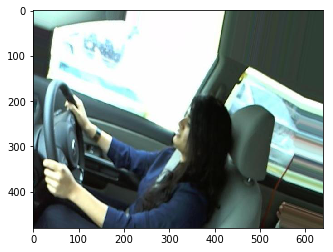

In [4]:
from sklearn.datasets import load_files
import os
import random

files1 = os.listdir("data/imgs/preview")
file = random.choice(files1)
while(os.path.isdir(file)):
    file = random.choice(files1)

img = imageio.imread(os.path.join("data/imgs/preview", file))
plt.imshow(img)
plt.show()

## 基准模型

项目将使用Kaggle中该[比赛的排名分数](https://www.kaggle.com/c/state-farm-distracted-driver-detection/leaderboard)做为基准模型。使用前10%的分数作为基准，第144名，最小损失值为0.25634。

# 方法
## 数据预处理和执行过程

这里因为数据集中的司机图像是从视频中截取出来的，可能存在两张甚至多种几乎一样的图像分别位于训练集和验证集中。训练后做验证时因为验证集存在几乎相同的图像，会导致验证分数被提高，但实际上模型仅仅是记住了该图片，因此分割验证集里需要采用一些策略。

决定使用sklearn中的`GroupKFold`对数据集进行划分，划分时使用`subject`列中的数据作为分组依据，`img`列和`classname`列分别作为数据的特征和目标分类。

In [5]:
imgs_pd = drivers_pd["img"]
class_pd = drivers_pd["classname"]
subject_pd = drivers_pd["subject"]
group_kfold = GroupKFold(n_splits=13)
group_kfold.get_n_splits(imgs_pd, class_pd, subject_pd)
kfolds = group_kfold.split(imgs_pd, class_pd, subject_pd)

这里将数据集划分为13组，每组拥有2名驾驶员的图像数据，每次K折验证使用24名驾驶员的数据做为训练集，使用2名驾驶员的数据做为验证集。

分组结束后获取每一组中的训练图像集和验证图像集，为训练图像集和验证图像集创建用于图像增强的生成器。图像生成器接口`ImageDataGenerator.flow_from_directory`接收的是一个文件夹，其中全部为训练集或者测试集，因此需要先将原数据集中的训练集和验证集分离出来，便于调用该接口。这里为了不复制太多图像文件占用空间，采用创建符号链接的方式将每次K折循环中取得的训练集和验证集的图像分离到新的train2和val2文件夹中。

编写一个于发离训练集和验证集的函数

In [6]:
import os
import shutil

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    
train_dir = "data/imgs/train2"
val_dir = "data/imgs/val2"
test_dir = "data/imgs/test"
saved_weights = "saved_weights"
if not os.path.exists(saved_weights):
    os.mkdir(saved_weights)

def split_imgs(target_dir, X, y):
    for img_name, target in zip(X, y):
        symlink_dir = os.path.join(target_dir, target)
        if not os.path.exists(symlink_dir):
            os.mkdir(symlink_dir)
        os.symlink('../../train/'+target+'/'+img_name, symlink_dir+'/'+img_name)

使用图像生成器接口`ImageDataGenerator.flow_from_directory`分别创建训练集的生成器和验证集的生成器，`class_mode`使用categorical类型，因为该项目一个多分类问题。

将训练代码编写为一个可以传入不同模型的函数，便于分别使用InceptionV3和Xception模型训练

In [12]:
from keras.callbacks import EarlyStopping

def train_model(get_model=None, epochs=10, 
                train_datagen=None, val_datagen=None, out_image_size=(150, 150), batch_size=16, val_loss_stop=None):
    i = 0
    for train_index, val_index in kfolds:
    #     print("TRAIN:", train_index, "VALID:", val_index)
        # 删除上次K折循环分离出的训练集和验证集文件，并重新创建目录
        rmrf_mkdir(train_dir)
        rmrf_mkdir(val_dir)

        X_train, X_val = imgs_pd[train_index], imgs_pd[val_index]
        y_train, y_val = class_pd[train_index], class_pd[val_index]
    #     print(X_train, X_val, y_train, y_val)

        # 分离训练集到新的目录中
        split_imgs(train_dir, X_train, y_train)

        # 分离验证集到新的目录中
        split_imgs(val_dir, X_val, y_val)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=out_image_size,
            batch_size=batch_size,
            class_mode='categorical')

        val_generator = val_datagen.flow_from_directory(
            val_dir,
            target_size=out_image_size,
            batch_size=batch_size,
            class_mode='categorical')

        model = get_model()
        save_file = saved_weights + '/' + model.name + '_' + str(i) + '.h5'
        print("model name:", model.name, ", will save weight file:", save_file)
        
        callbacks = []
        if not val_loss_stop:
            stop_callback = EarlyStopping(monitor='val_loss', min_delta=val_loss_stop)
            callbacks.append(stop_callback)
            
        history = model.fit_generator(
            train_generator,
            steps_per_epoch=len(X_train) // batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=len(X_val) // batch_size)
        
        # 保存权重
        model.save_weights(save_file)
        i += 1
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

设置训练参数

In [21]:
# 训练代数
epochs = 20
# 图像生成器输出的图像大小
out_image_size = (299, 299)

batch_size = 32

# 验证集损失值上涨多少即停止epochs
val_loss_stop = 0.01

# 训练集图像生成器
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255
    )

# 验证集图像生成器
val_datagen = ImageDataGenerator(rescale=1./255)

先使用InceptionV3模型，加载imagenet的预训练权重。这里不使用InceptionV3模型的顶部层，加入新的`GlobalAveragePooling2D`层和一个全连接层用于fine-tuning，同时关闭预训练模型的权重更新设置，避免在训练过程中打乱原imagenet的权重数据。因为项目总共有10种驾驶员行为类别，因此最顶层使用神经元个数为10的全连接层进行分类处理，使用softmax激活函数分类，该函数分类时将为每种类别计算出可能的概率值，概率值最高的类别即是该模型针对特定图像的分类预测结果。

模型使用`categorical_crossentropy`损失值函数，因为该分类是一个多分类问题。

In [14]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam, SGD
from keras.applications.inception_v3 import InceptionV3

In [23]:
def get_model_inceptionv3():
    base_model = InceptionV3(weights='imagenet', include_top=False)

    x = base_model.output
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions, name='inceptionv3')

#     op = SGD(lr=0.0001, decay=1e-8, momentum=0.9, nesterov=True)
    op = Adam(lr=0.0005)
    model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Found 20673 images belonging to 10 classes.
Found 1751 images belonging to 10 classes.
model name: inceptionv3 , will save weight file: saved_weights/inceptionv3_0.h5
Epoch 1/20
646/646 [==============================] - 847s 1s/step - loss: 0.7558 - acc: 0.7401 - val_loss: 0.9402 - val_acc: 0.6968
Epoch 2/20
646/646 [==============================] - 817s 1s/step - loss: 0.2239 - acc: 0.9295 - val_loss: 0.1532 - val_acc: 0.9525


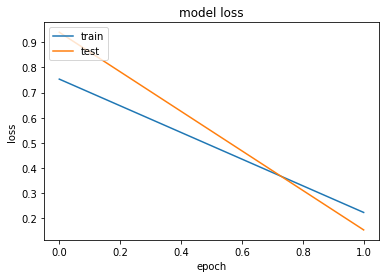

Found 20714 images belonging to 10 classes.
Found 1710 images belonging to 10 classes.
model name: inceptionv3 , will save weight file: saved_weights/inceptionv3_1.h5
Epoch 1/20
647/647 [==============================] - 854s 1s/step - loss: 0.5405 - acc: 0.8222 - val_loss: 1.2955 - val_acc: 0.6822
Epoch 2/20
647/647 [==============================] - 818s 1s/step - loss: 0.2101 - acc: 0.9363 - val_loss: 0.4554 - val_acc: 0.8608


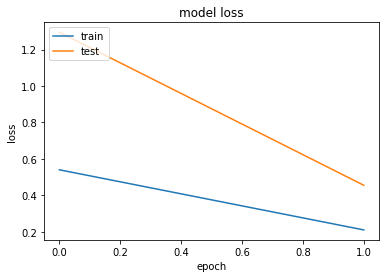

Found 20754 images belonging to 10 classes.
Found 1670 images belonging to 10 classes.
model name: inceptionv3 , will save weight file: saved_weights/inceptionv3_2.h5
Epoch 1/20
648/648 [==============================] - 862s 1s/step - loss: 0.5553 - acc: 0.8174 - val_loss: 0.8580 - val_acc: 0.7548
Epoch 2/20
648/648 [==============================] - 820s 1s/step - loss: 0.2135 - acc: 0.9337 - val_loss: 0.4685 - val_acc: 0.8552


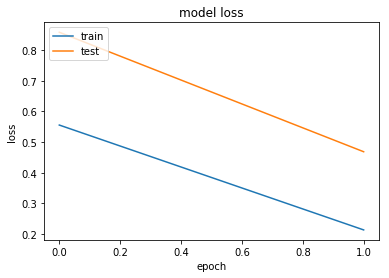

Found 20740 images belonging to 10 classes.
Found 1684 images belonging to 10 classes.
model name: inceptionv3 , will save weight file: saved_weights/inceptionv3_3.h5
Epoch 1/20
 72/648 [==>...........................] - ETA: 16:58 - loss: 1.8757 - acc: 0.3377

In [ ]:
# 开始训练
train_model(get_model_inceptionv3, epochs, 
            train_datagen, val_datagen, out_image_size, batch_size, val_loss_stop)

> 对图像数据进行预处理：旋转、添加噪点、模糊、缩小图片
>
> 在这一部分， 你需要清晰记录你所有必要的数据预处理步骤。在前一个部分所描述的数据的异常或特性在这一部分需要被更正和处理。需要考虑的问题有：
>
> 如果你选择的算法需要进行特征选取或特征变换，你对此进行记录和描述了吗？
数据的探索这一部分中提及的异常和特性是否被更正了，对此进行记录和描述了吗？
如果你认为不需要进行预处理，你解释个中原因了吗？

> 在这一部分， 你需要描述你所建立的模型在给定数据上执行过程。模型的执行过程，以及过程中遇到的困难的描述应该清晰明了地记录和描述。需要考虑的问题：

> 你所用到的算法和技术执行的方式是否清晰记录了？
在运用上面所提及的技术及指标的执行过程中是否遇到了困难，是否需要作出改动来得到想要的结果？
是否有需要记录解释的代码片段(例如复杂的函数）？

## 完善

> 在这一部分，你需要描述你对原有的算法和技术完善的过程。例如调整模型的参数以达到更好的结果的过程应该有所记录。你需要记录最初和最终的模型，以及过程中有代表性意义的结果。你需要考虑的问题：

> 初始结果是否清晰记录了？
完善的过程是否清晰记录了，其中使用了什么技术？
完善过程中的结果以及最终结果是否清晰记录了？

# 结果
## 模型的评价与验证

> 在这一部分，你需要对你得出的最终模型的各种技术质量进行详尽的评价。最终模型是怎么得出来的，为什么它会被选为最佳需要清晰地描述。你也需要对模型和结果可靠性作出验证分析，譬如对输入数据或环境的一些操控是否会对结果产生影响（敏感性分析sensitivity analysis）。一些需要考虑的问题：

> 最终的模型是否合理，跟期待的结果是否一致？最后的各种参数是否合理？
模型是否对于这个问题是否足够稳健可靠？训练数据或输入的一些微小的改变是否会极大影响结果？（鲁棒性）
这个模型得出的结果是否可信？

## 合理性分析

> 在这个部分，你需要利用一些统计分析，把你的最终模型得到的结果与你的前面设定的基准模型进行对比。你也分析你的最终模型和结果是否确确实实解决了你在这个项目里设定的问题。你需要考虑：

> 最终结果对比你的基准模型表现得更好还是有所逊色？
你是否详尽地分析和讨论了最终结果？
最终结果是不是确确实实解决了问题？

# 项目结论

## 可视化结果

> 在这一部分，你需要用可视化的方式展示项目中需要强调的重要技术特性。至于什么形式，你可以自由把握，但需要表达出一个关于这个项目重要的结论和特点，并对此作出讨论。一些需要考虑的：

> 你是否对一个与问题，数据集，输入数据，或结果相关的，重要的技术特性进行了可视化？
可视化结果是否详尽的分析讨论了？
绘图的坐标轴，标题，基准面是不是清晰定义了？

## 对项目的思考

> 在这一部分，你需要从头到尾总结一下整个问题的解决方案，讨论其中你认为有趣或困难的地方。从整体来反思一下整个项目，确保自己对整个流程是明确掌握的。需要考虑：

> 你是否详尽总结了项目的整个流程？
项目里有哪些比较有意思的地方？
项目里有哪些比较困难的地方？
最终模型和结果是否符合你对这个问题的期望？它可以在通用的场景下解决这些类型的问题吗？

## 需要作出的改进

> 在这一部分，你需要讨论你可以怎么样去完善你执行流程中的某一方面。例如考虑一下你的操作的方法是否可以进一步推广，泛化，有没有需要作出变更的地方。你并不需要确实作出这些改进，不过你应能够讨论这些改进可能对结果的影响，并与现有结果进行比较。一些需要考虑的问题：

> 是否可以有算法和技术层面的进一步的完善？
是否有一些你了解到，但是你还没能够实践的算法和技术？
如果将你最终模型作为新的基准，你认为还能有更好的解决方案吗？

# 参考文献
- [1]Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, Zbigniew Wojna. [
Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567). arXiv:1512.00567, 2015.
- [2]François Chollet. [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/pdf/1610.02357). arXiv prepr int arXiv:1610.02357, 2016.
- [3]黄文坚. [CNN浅析和历年ImageNet冠军模型解析](http://www.infoq.com/cn/articles/cnn-and-imagenet-champion-model-analysis). 发表时间: 2017年5月22日.
- [4]Kaggle. [State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection). 2016.
- [5]The Keras Blog. [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). 2016
By Francois Chollet.